In [51]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

%matplotlib ipympl

In [52]:
def make_detector_for_gauss_rays(dsize, npix, n_rays):
    x = np.linspace(-dsize / 2, dsize / 2, npix)
    x,y = np.meshgrid(x,x)
    
    r = np.array([x.ravel(), y.ravel()]).T
    r = np.broadcast_to(r, [n_rays, *r.shape])
    r = np.swapaxes(r, 0, 1)

    return r

In [53]:
n_rays = 1
wavelength = 0.1
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)
deflection = -0.2
a = 5
b = 5
d = 2*a*deflection
spacing = ((a+b)/abs(d))*wavelength

size = 128
det_shape = (size, size)
pixel_size = 0.1
dsize = det_shape[0] * pixel_size

wo = 0.4
wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths 

tilt_yx = np.tan(np.deg2rad((0, 10)))

In [54]:

components = (
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=0,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    # comp.Biprism(
    #     z=a,
    #     offset=0.0,
    #     rotation=0.0,
    #     deflection=deflection,
    # ),
    # comp.Lens(
    #     z=a,
    #     f = 2.0,
    # ),
    comp.AccumulatingDetector(
        z=a+b,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=64,
    ),
)

In [55]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays))
image = model.detector.get_image(rays[-1])
det_x = np.linspace(-det_shape[1]//2*pixel_size, det_shape[1]//2*pixel_size, det_shape[1])

In [56]:
start_rays = rays[0].data[0:4, :].T
end_rays = rays[-1].data[0:4, :].T
path_length = rays[-1].path_length[0::5]

# Split the array into two parts along the first axis
split_start_rays = np.split(start_rays, n_rays, axis=0)
split_end_rays = np.split(end_rays, n_rays, axis=0)
split_path_length = np.split(path_length, n_rays, axis=0)

# Stack the split arrays along a new axis
rayset0 = np.stack(split_start_rays, axis=-1)
rayset1 = np.stack(split_end_rays, axis=-1)
opd = np.stack(split_path_length, axis=-1)

xStart, yStart = rayset0[0, 0], rayset0[0, 2]
lStart, mStart = rayset0[0, 1], rayset0[0, 3]

xEnd, yEnd = rayset1[0, 0], rayset1[0, 2]
lEnd, mEnd = rayset1[0, 1], rayset1[0, 3]


In [ ]:

#get misalignment vectors
x1m = rays[1].data[0, 0::5]
phi_x1m = rays[1].data[1, 0::5]
y1m = rays[1].data[2, 0::5]
phi_y1m = rays[1].data[3, 0::5]

x2m = rays[-2].data[0, 0::5]
phi_x2m = rays[-2].data[1, 0::5]
y2m = rays[-2].data[2, 0::5]
phi_y2m = rays[-2].data[3, 0::5]

r1m = np.array([x1m, y1m])
p1m = np.array([phi_x1m, phi_y1m,])
r2m = np.array([x2m, y2m])
p2m = np.array([phi_x2m, phi_y2m,])

In [57]:

r2 = make_detector(dsize, size, n_rays)
r = r2.copy()

r[:, :,  0] = r2[:, :,  0] - xEnd
r[:, :,  1] = r2[:, :,  1] - yEnd

[[1.76326981]
 [0.        ]] [[0.17632698]
 [0.        ]] [[0.]
 [0.]] [[0.17632698]
 [0.        ]]
(2, 1) (2, 1) (2, 1) (2, 1)


In [58]:
A, B, C, D = gbd.differential_matrix(rayset1, dPx, dPy, dHx, dHy)

Qinv = gbd.calculate_Qinv(z_r)
Qpinv = gbd.calculate_Qpinv(A, B, C, D, Qinv)

field = gbd.propagate_misaligned_gaussian(Qinv, Qpinv, r, r1m, p1m, r2m, p2m, r2, k, A, B, path_length).reshape(det_shape)

Text(0.5, 0.98, 'GBP')

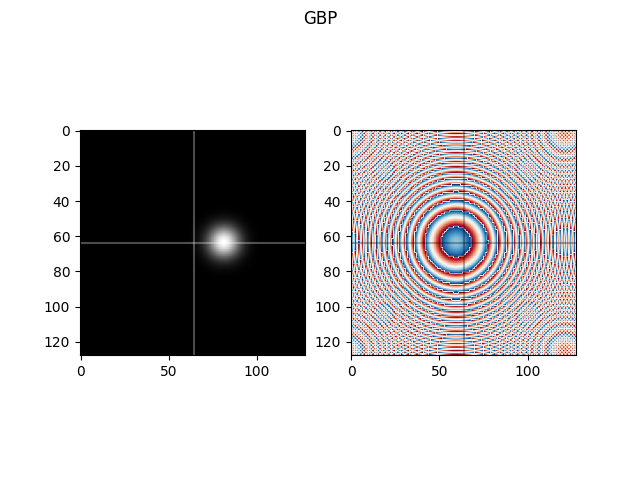

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.imshow(np.angle(field),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("GBP")

In [60]:
# AppWindow = QApplication(sys.argv)
# viewer = TemGymWindow(model)
# viewer.show()
# AppWindow.exec()